# 可解釋機器模型 Explainable AI<br>

機器學習方法中許多演算法的計算方式較複雜，加上實務上我們要做決策時，常需要了解模型為何做出這樣的決策。

以此筆銀行帳戶流失資料為例，當我們由機器學習模型預測出哪些顧客會流失、哪些不會時，會想要知道模型判斷他是流失顧客的重要因素為何。

而可解釋機器模型 Explainable AI 即可幫我們解決此問題。目前主要使用有以下四種方法：
- LIME
- SHAP
- LRP(Layer-wise relevance propagation)
- Counterfactual Explaination

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('Churn Modeling.csv')

In [3]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


### EDA

In [8]:
data.Exited.value_counts()
# 一萬筆資料中，流失的顧客有2037位，佔20.4%

0    7963
1    2037
Name: Exited, dtype: int64

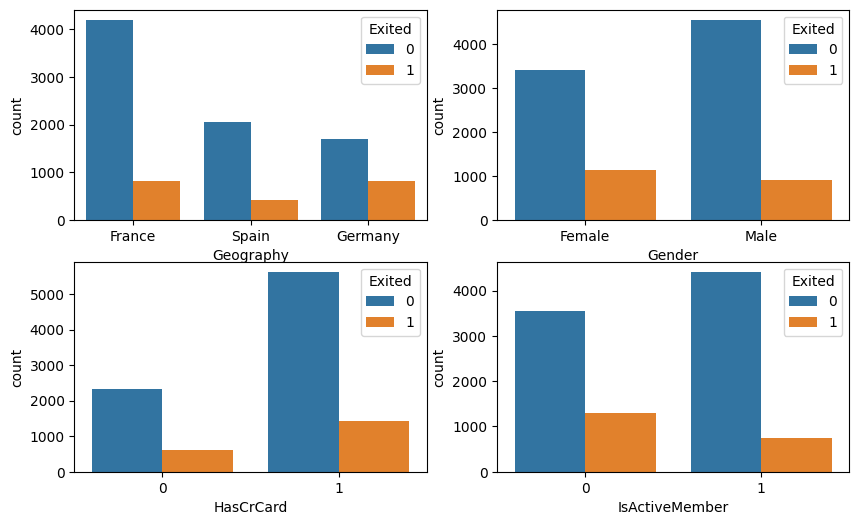

In [9]:
# 類別變數直方圖

fig, axar = plt.subplots(2, 2, figsize=(10,6))
sns.countplot(x='Geography', hue='Exited', data=data, ax=axar[0][0])
sns.countplot(x='Gender', hue='Exited', data=data, ax=axar[0][1])
sns.countplot(x='HasCrCard', hue='Exited', data=data, ax=axar[1][0])
sns.countplot(x='IsActiveMember', hue='Exited', data=data, ax=axar[1][1])
plt.show()
# 法國顧客最多，流失率相較西班牙及德國顧客也較低
# 女性顧客流失率相較男性顧客高
# 擁有信用卡的人較多
# 雖沒有銀行帳戶，但仍和銀行有債券、保險往來的顧客，在流失銀行帳戶的比例比較高

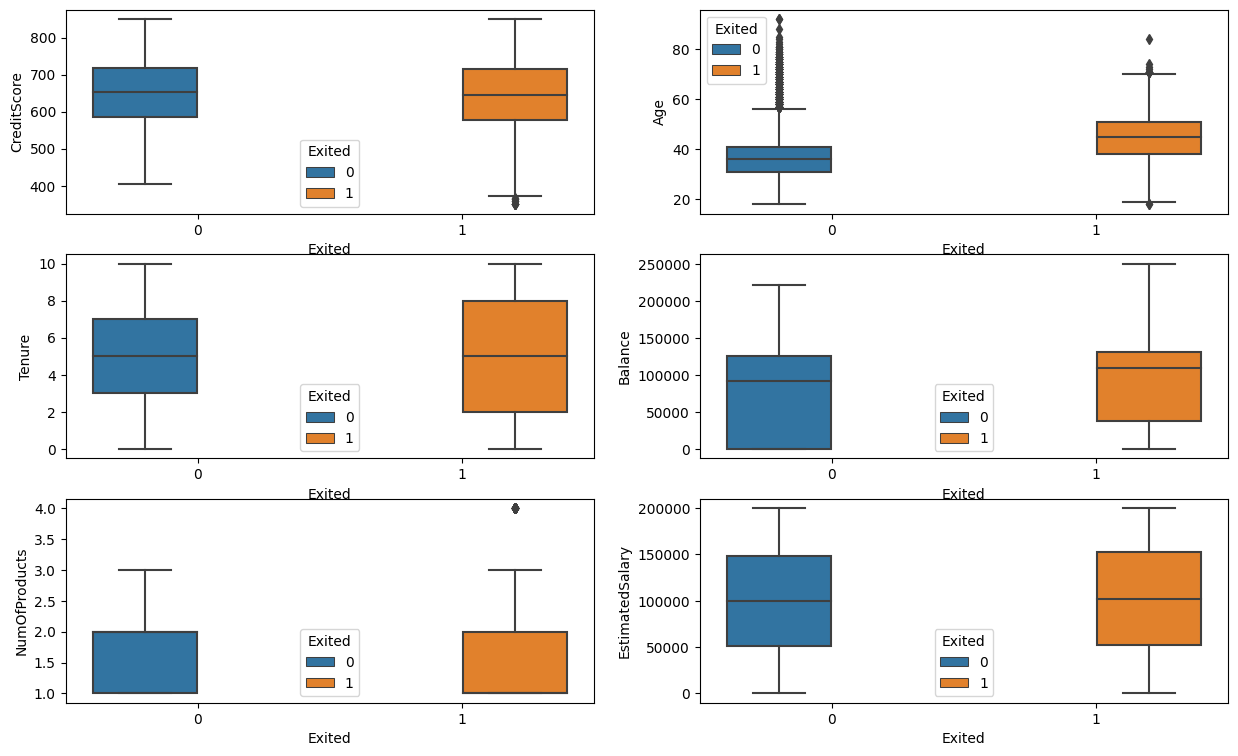

In [10]:
# 連續變數盒型圖

fig, axar = plt.subplots(3, 2, figsize=(15,9))
sns.boxplot(x='Exited', y='CreditScore', hue='Exited', data=data, ax=axar[0][0])
sns.boxplot(x='Exited', y='Age', hue='Exited', data=data, ax=axar[0][1])
sns.boxplot(x='Exited', y='Tenure', hue='Exited', data=data, ax=axar[1][0])
sns.boxplot(x='Exited', y='Balance', hue='Exited', data=data, ax=axar[1][1])
sns.boxplot(x='Exited', y='NumOfProducts', hue='Exited', data=data, ax=axar[2][0])
sns.boxplot(x='Exited', y='EstimatedSalary', hue='Exited', data=data, ax=axar[2][1])
plt.show()
# 流失的顧客和保留的顧客在信用分數上沒有什麼差異
# 流失的顧客年齡較保留的顧客高
# 有極端任期的顧客較易流失
# 流失的顧客中銀行帳戶餘額較多
# 流失與否在商品數及薪水上無顯著差異

### Feature Engineering

In [11]:
modelData = data.drop(columns = ['RowNumber','Surname', 'CustomerId'])

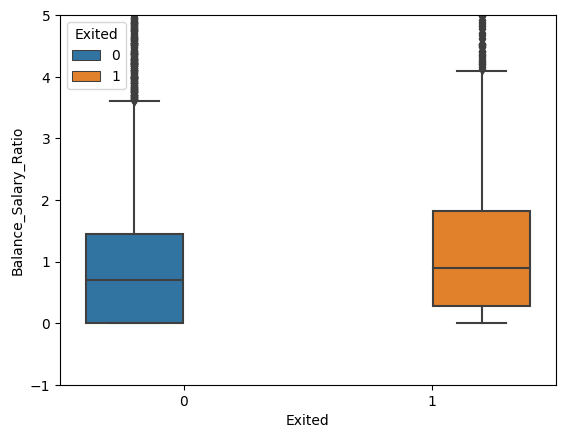

In [12]:
# 新增變數為「銀行帳戶餘額跟薪水的比例」

modelData['Balance_Salary_Ratio'] = modelData['Balance']/modelData['EstimatedSalary']
sns.boxplot(x='Exited', y='Balance_Salary_Ratio', hue='Exited', data=modelData)
plt.ylim(-1,5)
plt.show()
# 流失顧客存款和薪水比值較高

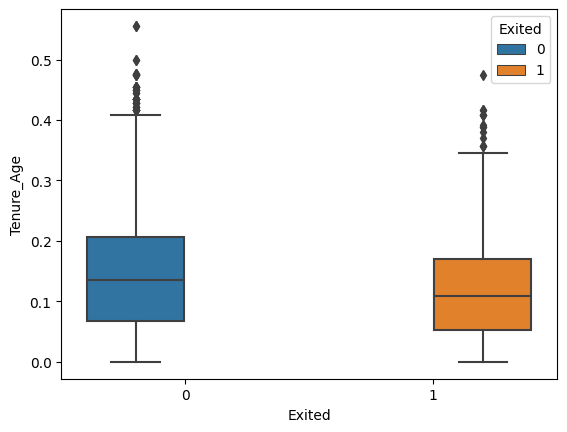

In [13]:
# 新增變數為「任期除以年齡」

modelData['Tenure_Age'] = modelData.Tenure/(modelData.Age)
sns.boxplot(x='Exited', y='Tenure_Age', hue='Exited', data=modelData)
plt.show()

In [14]:
# 新增變數為「信用分數除以年齡」

modelData['CreditScore_Age'] = modelData.CreditScore/(modelData.Age)

In [22]:
modelData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerId            10000 non-null  int64  
 1   CreditScore           10000 non-null  int64  
 2   Geography             10000 non-null  object 
 3   Gender                10000 non-null  object 
 4   Age                   10000 non-null  int64  
 5   Tenure                10000 non-null  int64  
 6   Balance               10000 non-null  float64
 7   NumOfProducts         10000 non-null  int64  
 8   HasCrCard             10000 non-null  int64  
 9   IsActiveMember        10000 non-null  int64  
 10  EstimatedSalary       10000 non-null  float64
 11  Exited                10000 non-null  int64  
 12  Balance_Salary_Ratio  10000 non-null  float64
 13  Tenure_Age            10000 non-null  float64
 14  CreditScore_Age       10000 non-null  float64
dtypes: float64(5), int64

### Model Fitting

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [23]:
modelData.loc[modelData['HasCrCard'] == 0,'HasCrCard'] = -1
modelData.loc[modelData['IsActiveMember'] == 0,'IsActiveMember'] = -1

modelData = pd.get_dummies(modelData, columns=['Geography', 'Gender'])

In [31]:
X = modelData.drop(['Exited'], axis=1)
y = modelData.Exited

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### Model 1: Random Forest 

In [34]:
rfModel = RandomForestClassifier(max_features='log2', n_estimators=80)
classifier = rfModel.fit(np.array(X_train), np.array(y_train))
predicted = rfModel.predict(X_test)

print(classification_report(np.array(y_test), predicted))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1595
           1       0.74      0.50      0.60       405

    accuracy                           0.86      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



X has feature names, but RandomForestClassifier was fitted without feature names


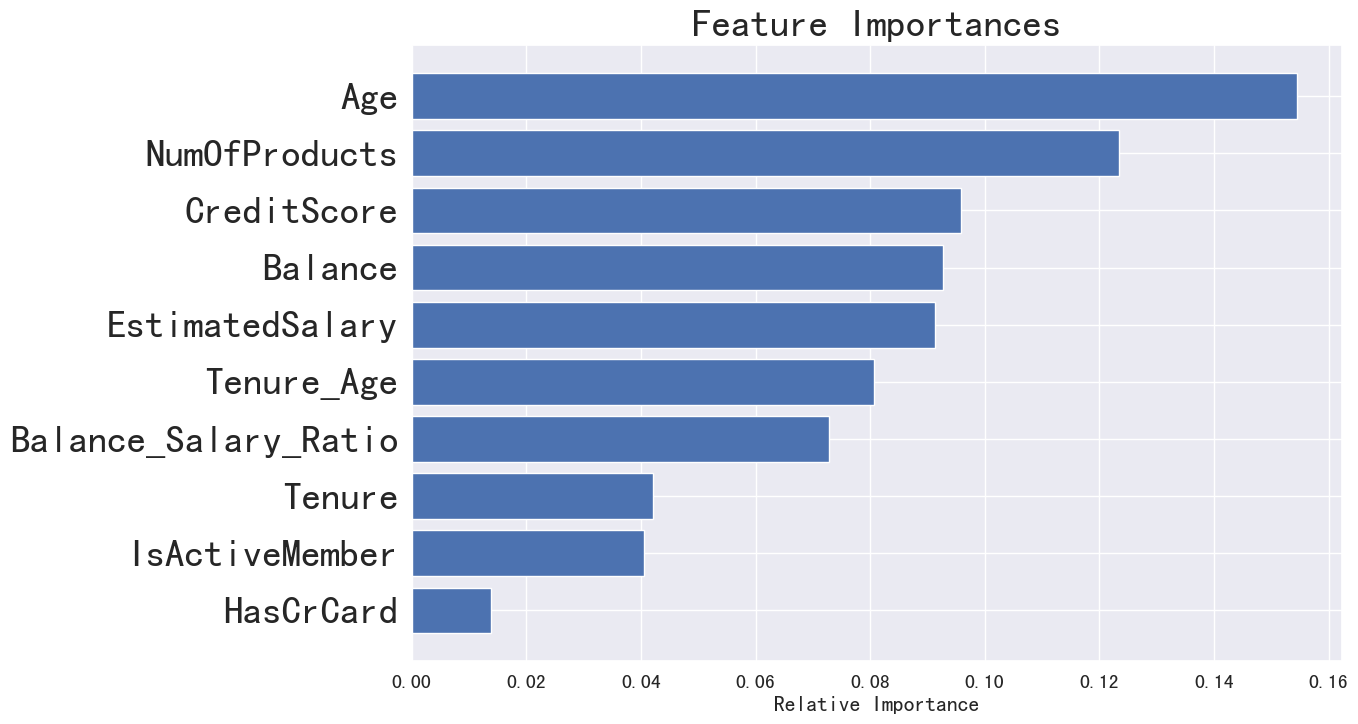

In [36]:
# 特徵重要度
sns.set(style='darkgrid', font='SimHei', rc={'figure.figsize':(12, 8)}, font_scale=1.3)# 設定讓圖顯示中文

topn = 10
importances = rfModel.feature_importances_[:topn]
indices = np.argsort(importances)[:topn]
features = X_train.columns[:topn]
plt.title('Feature Importances', fontsize=28)
plt.barh(range(len(indices[:topn])), importances[indices], color='b', align='center')
plt.yticks(range(len(indices[:topn])), [features[i] for i in indices], fontsize=28)
plt.xlabel('Relative Importance')
plt.show()

由上圖可知，前十名重要變數有以下：

年齡、商品數量、信用分數、帳戶餘額、薪資、任期除以年齡、餘額占薪水的比例、任期、是否與銀行還有往來、是否有信用卡

##### Model 1: XGBoost

In [40]:
# 建立XGBClassifier 模型
xgboostModel = XGBClassifier(n_estimators=100, learning_rate= 0.3)
# 使用訓練資料訓練模型
classifier = xgboostModel.fit(np.array(X_train), np.array(y_train))
# 使用訓練資料預測分類
predicted = xgboostModel.predict(X_test)

print(classification_report(np.array(y_test), predicted))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1595
           1       0.69      0.55      0.61       405

    accuracy                           0.86      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



為理解影響XGBoost 模型預測的決策因素，這裡使用可解釋機器模型的套件：**SHAP**

可以計算每個特徵的shap value，來衡量該特徵對預測的貢獻度。

- 點的顏色: Feature value 的大小，越紅越高、越藍越低；
- X 軸： shape value 的範圍

In [44]:
import shap

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


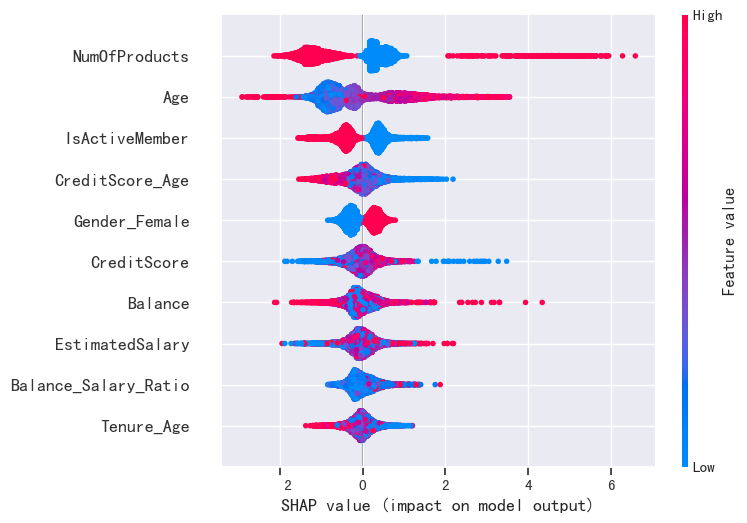

In [60]:
# Summary Plot 對整體資料解釋

explainer = shap.Explainer(classifier)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, max_display = 10) #max_display 設定顯示前幾重要的特徵

由上圖可以看出重要特徵的影響有以下特徵：
- 購買的商品數量(NumOfProducts)、年齡(Age)越極端的多或極端的少，都會對模型很有貢獻度。
- 沒有和銀行有往來的顧客(IsActiveMember)越傾向預測為流失客戶。
- 信用分數跟年齡比值(CreditScore_Age)越低，越傾向預測為流失客戶。
- 女性較易為流失客戶。

購買的商品數量、年齡、是否銀行有往來是隨機森林跟XGBoost 都顯示重要的變數。

我們還可以利用SHAP 進一步看個別客戶被模型預測為流失或非流失的原因。

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


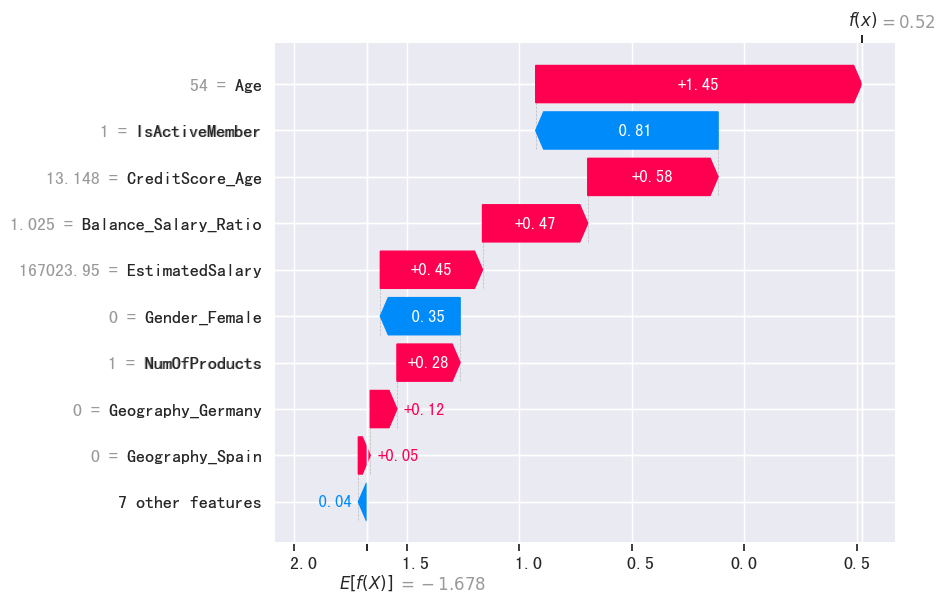

In [107]:
# waterfall 對單一資料解釋

idx = np.where(classifier.predict(X_train) == 1)[0] # 被預測為1（流失）的index
shap.plots.waterfall(shap_values[idx[0]])

In [108]:
np.array(y_train)[idx[0]] # 實際上此筆資料也是流失顧客

1

上圖為模型預測為流失顧客的第一位顧客，紅色代表正的貢獻度、藍色代表負的貢獻度
- 正面的影響：
  - Age: 是54歲的顧客
  - CreditScore_Age: 信用分數跟年齡比值為13.148，低於平均比值17.9
  - Balance_Salary_Ratio: 銀行帳戶餘額跟薪水的比例為1.025，高於中位數的0.74，但仍使模型傾向預測為流失顧客
  - EstimatedSalary: 薪水高於整體資料的Q3，影響預測為流失顧客
- 負面的影響：
  - IsActiveMember: 此位顧客仍是往來客戶，使模型預測降低流失機率
  - Gender: -0.3

In [134]:
retain_customer = np.where(np.array(y_train)[idx] == 0)[0] # 非流失顧客的index
np.array(y_train)[retain_customer[0]] # 實際上此筆資料非流失顧客

0

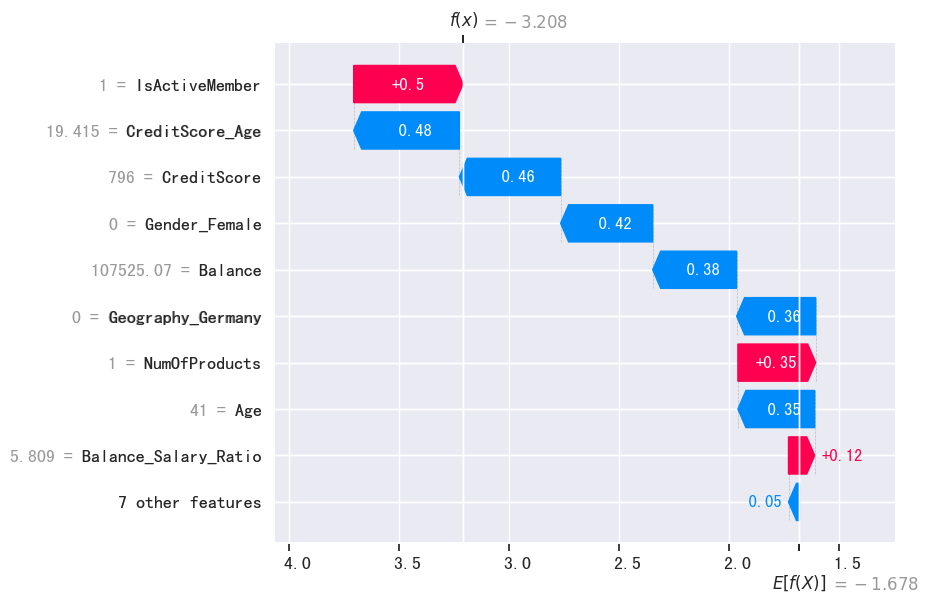

In [135]:
shap.plots.waterfall(shap_values[retain_customer[0]])

上圖為模型預測為非流失顧客的個別特徵影響

# 模型解釋

在經過集成式(ensemble)學習之後的 tree based 機器學習演算法，該方法通常可以提高相當不錯的模型成效，但是其中的理論很難讓人去參透，常常被人詬病說是一個黑盒子。 

一個黑盒子是很難去判斷裡面做了什麼事情，我們如果要進行做決策、改良模型等等，都需要了解這個演算法到底學習到了什麼。

這時候模型解釋就相當重要，有一塊領域 Explainable AI 就是在探討這方面的知識。

機器學習與人一樣不是聖賢，還是會有犯錯的可能性。當發生預測錯誤的時候，若我們能夠透過解釋型 AI 告訴合理的原因，或許可為下一次改版做一些根因探討。「科技始終來自於人性」，我們有時候很難跟我們的需求方講解或討論這些演算法的深奧的原理或數學知識，也隨著我們越來越倚重機器學習產出的結果，我們勢必也需要能了解其中的原因，我們才可以用的安心，讓大家放心。

## Shap

Shap 最早來源是賽局理論，詳細可以[參考wiki](https://en.wikipedia.org/wiki/Shapley_value)。Shap 是將模型的預測解釋分析成每個因子的貢獻，計算每個特徵的 shapely value，來衡量該特徵對預測的貢獻度。如此一來，我們可以詳細了解每個因子的貢獻程度。

[github 連結](https://github.com/slundberg/shap)

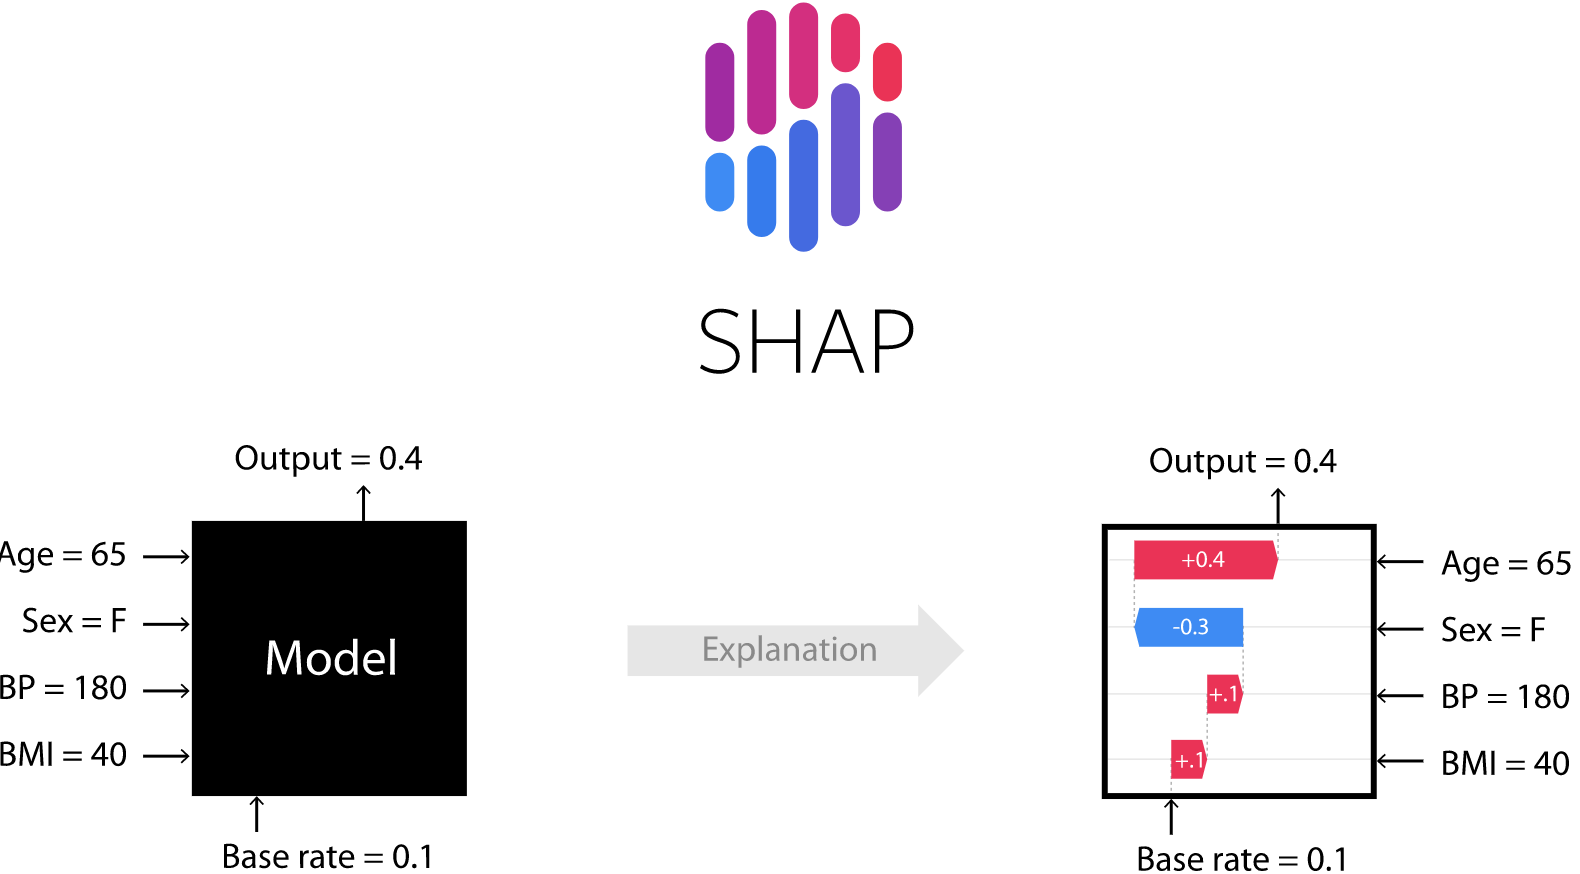

Shap 是一個可以將機器學習透過視覺化方式輔助理解的 Explainable AI 套件，優點如下

- 簡單安裝
- 視覺化呈現

### 實作程式碼

In [15]:
import pandas as pd
import xgboost
import shap
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('Book_Purchased.txt')

for _ , col in enumerate(dataset.columns.tolist()):
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].astype('category').cat.codes

X = dataset[['Gender', 'Age', 'Salary', 'VIP']]
y = dataset[['Purchased']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
classifier = xgboost.XGBClassifier().fit(X_train, y_train)

explainer = shap.Explainer(classifier)
shap_values = explainer(X_train)

/Users/tengyuan/opt/anaconda3/envs/ML/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [4]:
dataset

,ID,Gender,Age,Salary,VIP,Purchased
0,97,1,22,20900.0,0,0
1,392,1,43,22000.0,0,0
2,155,0,29,47300.0,0,0
3,64,0,30,62700.0,0,0
4,382,1,22,83600.0,0,0
...,...,...,...,...,...,...
395,196,0,49,45100.0,1,1
396,220,1,54,25300.0,1,1
397,130,0,53,22000.0,0,1
398,305,1,23,36300.0,0,0


#### 單一資料解釋

第一筆資料有 0.98 預測為 Purchased = 1

In [5]:
X_train[:5]

,Gender,Age,Salary,VIP
336,1,61,158400.0,0
64,0,62,91300.0,0
55,0,27,60500.0,0
106,0,29,38500.0,0
300,0,61,41800.0,0


In [6]:
classifier.predict_proba(X_train[:1])

array([[0.01796407, 0.98203593]], dtype=float32)

紅色代表正的貢獻度、藍色代表負的貢獻度
- 正面的影響：
  - Age: +3.3
  - Salary: +2
- 負面的影響：
  - VIP: -0.32
  - Gender: -0.3

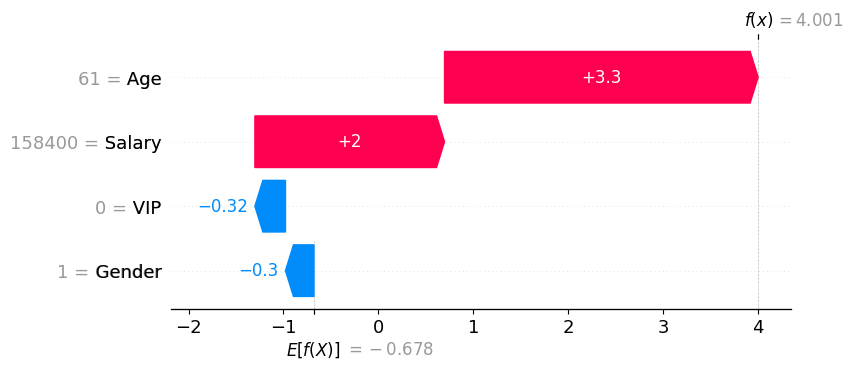

In [16]:
# waterfall
shap.plots.waterfall(shap_values[0])

In [17]:
# force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_train.iloc[0,:])

#### 整體資料解釋

##### summary plot

- 點的顏色: Feature value 的大小，越紅越高、越藍越低；
- X 軸： shape value 的範圍

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


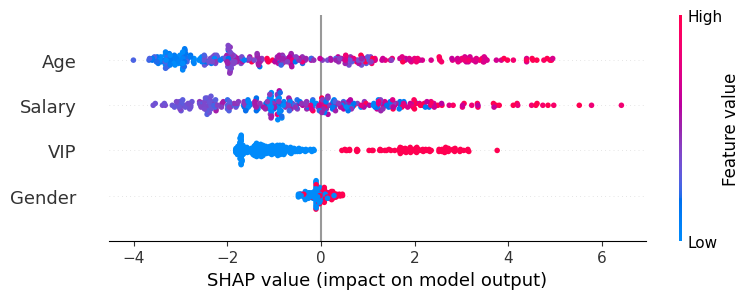

In [18]:
shap.summary_plot(shap_values, X_train)

- VIP 的註記對於分類很有幫助
- Age、Salary 的大小某種程度都會影響預測值；而 Gender 並沒有什麼幫助
- 年齡越小對於預測值的貢獻度越低

##### Aggregated force plot

這張圖真的是 shap 一大賣點，還可以操作 x 、ｙ 軸 切換不同的維度看資料

In [19]:
# 切第 0~4 筆資料查看
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0:5,:],X.iloc[0:5,:], plot_cmap="DrDb")

In [20]:
# 看整體資料
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values, X_train, plot_cmap="DrDb")

#### 其他圖參考

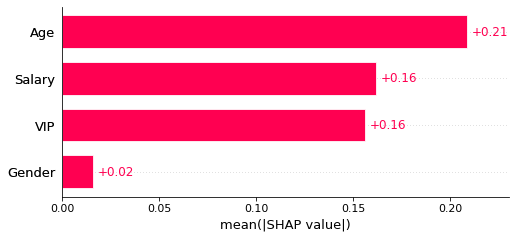

In [44]:
shap.plots.bar(shap_values)

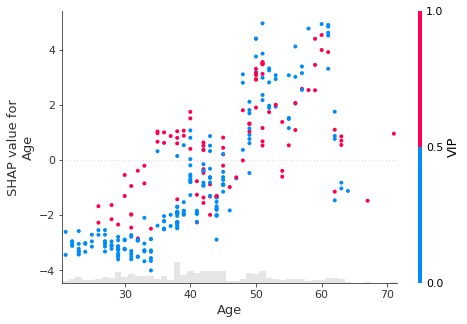

In [156]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:,"VIP"])

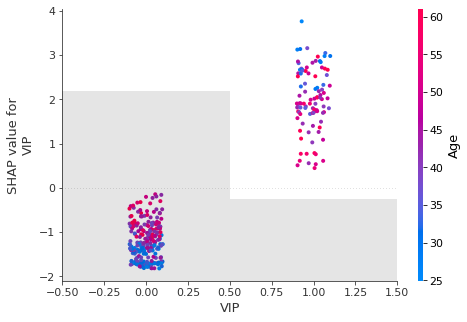

In [157]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"VIP"], color=shap_values[:,"Age"])

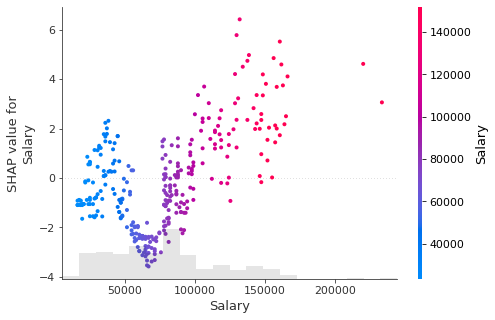

In [158]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"Salary"], color=shap_values[:,"Salary"])